This notebook is part of the `kikuchipy` documentation https://kikuchipy.org.
Links to the documentation won't work from the notebook.

# Visualizing patterns

The [EBSD](reference.rst#kikuchipy.signals.EBSD) and
[EBSDMasterPattern](reference.rst#kikuchipy.signals.EBSDMasterPattern) signals
have a powerful and versatile
[plot()](http://hyperspy.org/hyperspy-doc/current/api/hyperspy.signal.html#hyperspy.signal.BaseSignal.plot)
method provided by HyperSpy. Its uses are greatly detailed in HyperSpy's
[visualisation user guide](http://hyperspy.org/hyperspy-doc/current/user_guide/visualisation.html).
This section details example uses specific to EBSD and EBSDMasterPattern
signals.

Let's import the necessary libraries and a Nickel EBSD test data set
<cite data-cite="anes2019electron">Ånes et al. (2019)</cite>:

In [32]:
# exchange inline for qt5 for interactive plotting from the pyqt package
%matplotlib inline

import hyperspy.api as hs
import kikuchipy as kp
import matplotlib.pyplot as plt
import numpy as np
import skimage.color as skc
import skimage.exposure as ske
import skimage.transform as skt


# Use kp.load("data.h5") to load your own data
s = kp.data.nickel_ebsd_large(allow_download=True)  # External download
s

<EBSD, title: patterns Scan 1, dimensions: (75, 55|60, 60)>

## Navigate in custom map

Correlating results from e.g. crystal and phase structure determination, i.e.
indexing, with experimental patterns can inform their interpretation. When
calling `plot` without any input parameters, the navigator map is a grey scale
image with pixel values corresponding to the sum of all detector intensities
within that pattern:

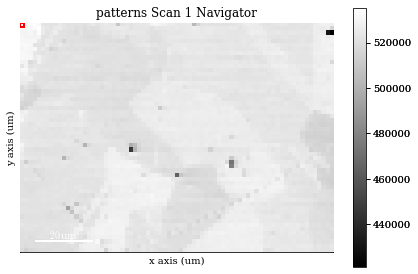

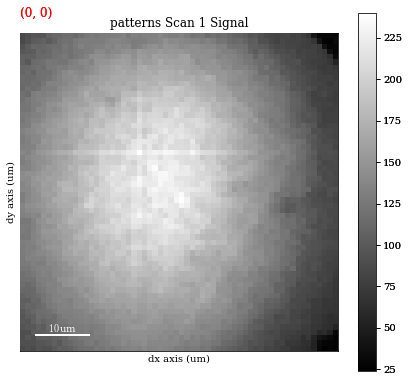

In [33]:
s.plot()

The upper panel shows the navigation axis, in this case 2D, with the current
beam position in the upper left corner shown as a red square the size of one
pixel. This square can be made larger/smaller with <kbd>+</kbd>/<kbd>-</kbd>.
The navigation axis can be navigated either by the keyboard arrows or the mouse.
The lower panel shows the pattern in the current beam position.

Any
[BaseSignal](http://hyperspy.org/hyperspy-doc/current/api/hyperspy.signal.html#hyperspy.signal.BaseSignal)
signal with a two-dimensional `signal_shape` corresponding to the scan
`navigation_shape` can be passed in to the `navgiator` parameter in
[plot()](http://hyperspy.org/hyperspy-doc/current/api/hyperspy.signal.html#hyperspy.signal.BaseSignal.plot),
including a virtual image showing diffraction contrast, any quality metric map,
or an orientation map or a phase map.

## Virtual image

A virtual backscatter electron (VBSE) image created from any detector region of
interest with the
[get_virtual_bse_intensity()](reference.rst#kikuchipy.signals.EBSD.get_virtual_bse_intensity)
method or
[get_rgb_image()](reference.rst#kikuchipy.generators.VirtualBSEGenerator.get_rgb_image)
explained in the
[virtual backscatter electron imaging](virtual_backscatter_electron_imaging.rst)
section, can be used as a navigator for a scan `s`:

In [34]:
vbse_gen = kp.generators.VirtualBSEGenerator(s)
print(vbse_gen)
print(vbse_gen.grid_shape)

VirtualBSEGenerator for <EBSD, title: patterns Scan 1, dimensions: (75, 55|60, 60)>
(5, 5)


In [35]:
vbse_rgb = vbse_gen.get_rgb_image(r=(3, 1), b=(3, 2), g=(3, 3))
vbse_rgb

<VirtualBSEImage, title: , dimensions: (|75, 55)>

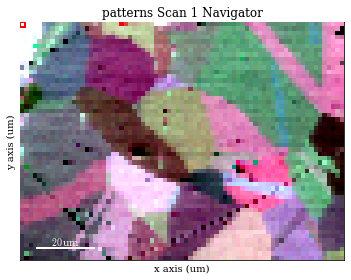

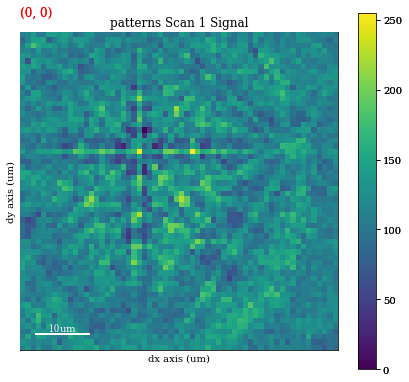

In [48]:
s.plot(navigator=vbse_rgb, cmap="viridis")

## Any image

Images loaded into a
[Signal2D](http://hyperspy.org/hyperspy-doc/current/api/hyperspy._signals.signal2d.html#hyperspy._signals.signal2d.Signal2D)
can be used as navigators, like a quality metric map like the
[image quality map](feature_maps.ipynb#Image-quality) calculated using
[get_image_quality()](reference.rst#kikuchipy.signals.EBSD.get_image_quality):

In [38]:
s.remove_static_background()
s.remove_dynamic_background()

Removing the static background:
[########################################] | 100% Completed |  0.3s
Removing the dynamic background:
[########################################] | 100% Completed |  1.6s


Calculating the image quality:
[########################################] | 100% Completed |  0.7s


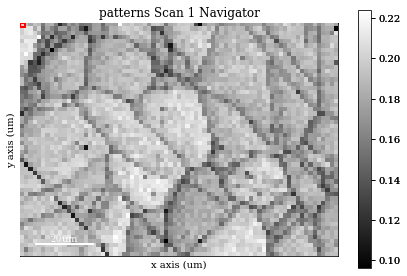

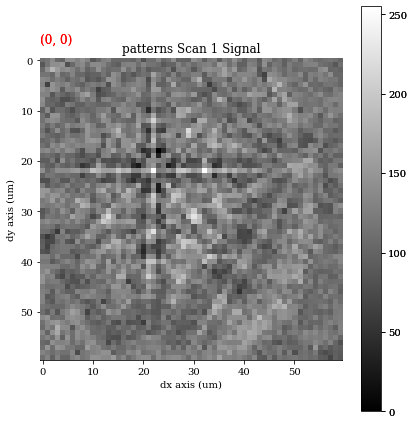

In [49]:
iq = s.get_image_quality()
s_iq = hs.signals.Signal2D(iq)
s.plot(navigator=s_iq, scalebar=False)

Using colour images (apart from creating RGB virtual BSE images, as shown
above), e.g. an orientation `om` or phase map, is a bit more involved
(especially so when the image doesn't have the correct pixel shape, as our
orientation map exported from MTEX has below):

In [51]:
om = plt.imread('_static/image/visualizing_patterns/om.png')
print(om.shape, om.dtype)
om_resized = skt.resize(
    om,
    output_shape=s.axes_manager.navigation_shape[::-1] + (3,),
    anti_aliasing=False
)
om_scaled = ske.rescale_intensity(om_resized, out_range=np.uint8)
s_om = hs.signals.Signal2D(om_scaled)
s_om

(764, 1036, 3) float32


<Signal2D, title: , dimensions: (55|3, 75)>

In [52]:
s_om = s_om.transpose(signal_axes=1)
print(s_om, s_om.data.dtype)

<Signal1D, title: , dimensions: (75, 55|3)> uint8


In [53]:
s_om.change_dtype('rgb8')
print(s_om, s_om.data.dtype)

<Signal2D, title: , dimensions: (|75, 55)> [('R', 'u1'), ('G', 'u1'), ('B', 'u1')]


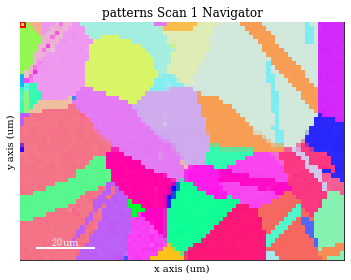

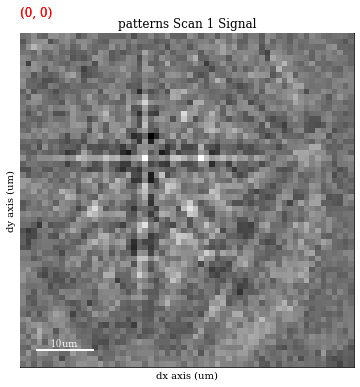

In [54]:
s.plot(navigator=s_om, colorbar=False)

HyperSpy provides the function
[plot_signals()](http://hyperspy.org/hyperspy-doc/current/api/hyperspy.drawing.utils.html#hyperspy.drawing.utils.plot_signals)
to plot multiple signals with the same navigator, as explained in their
[user guide](http://hyperspy.org/hyperspy-doc/current/user_guide/visualisation.html#plotting-several-signals).
This enables e.g. plotting of experimental and simulated patterns side by side
as a visual inspection of the indexing results:

In [1]:
# TODO:
#  1. Index the "large" Ni data set by pattern matching to a dictionary from the test master pattern
#  2. Add the returned crystal map to the small and "large" Ni data sets
#  3. Get a dictionary of the best matching patterns
#  4. Plot them side by side with the experimental patterns!

## Plot master patterns

[EBSDMasterPattern](reference.rst#kikuchipy.signals.EBSDMasterPattern) signals
can be navigated along their energy axis and/or the their northern/southern
hemisphere:

In [45]:
s_mp = kp.data.nickel_ebsd_master_pattern_small(
    projection="spherical", hemisphere="both"
)  # Only a single energy, 20 keV
s_mp.axes_manager

<Axes manager, axes: (2|401, 401)>
            Name |   size |  index |  offset |   scale |  units 
================ | ====== | ====== | ======= | ======= | ====== 
               y |      2 |      0 |       0 |       1 | hemisphere 
---------------- | ------ | ------ | ------- | ------- | ------ 
           width |    401 |        |  -2e+02 |       1 |     px 
          height |    401 |        |  -2e+02 |       1 |     px

As can be seen from the axes manager, the master pattern has two navigation
axes, a north and south hemisphere, thus, when plotting, we get a slider as a
navigator when plotting:

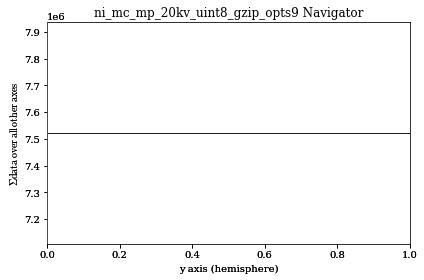

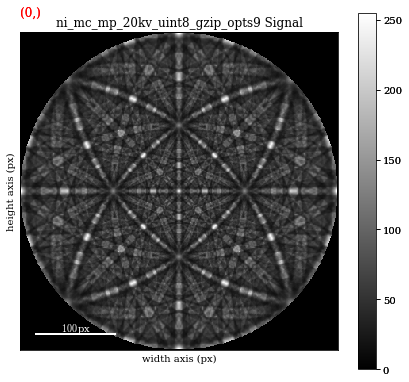

In [46]:
s_mp.plot()